In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sqlite3

sys.path.insert(0, '/home/nsryan/Desktop/arfc/transition-scenarios/scripts')
mycolors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255"]
plt.rcParams.update({'font.size': 15})

In [8]:
import cymetric as cym
import transition_metrics as tm
import dataframe_analysis as dta

# Scope
The scope of this notebook includes the historically deployed LWRs in the United States.

In [3]:
current_outfile = 'input_files/lwr_only.sqlite'

## Reactor Deployment

In [4]:
current_lwr = ['Mine', 'Mill', 'Conversion',
               'Enrichment', 'FuelFab', 'United States Nuclear',
               'USA', 'LWR', 'NuclearRepository', 'LWReactors']

In [5]:
current_reactors = tm.get_lwr_totals(current_outfile, current_lwr)
current_reactors = dta.add_year(current_reactors)

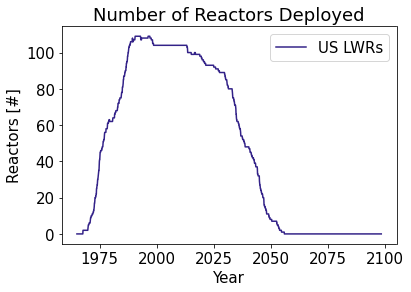

In [6]:
plt.plot(current_reactors['Year'], current_reactors['lwr_total'], label='US LWRs', color=mycolors[0])
plt.title('Number of Reactors Deployed')
plt.xlabel('Year')
plt.ylabel('Reactors [#]')
# plt.yscale('log')
plt.legend()

## Energy Output

In [7]:
current_energy = tm.get_annual_electricity(current_outfile)

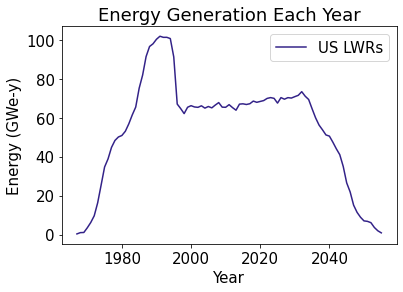

In [8]:
# Plot the yearly energy

plt.plot(current_energy['Year'], current_energy['Energy'], label='US LWRs', color=mycolors[0])

plt.title('Energy Generation Each Year')
plt.xlabel('Year')
plt.ylabel('Energy (GWe-y)')
plt.legend()

## Material Transactions

In [9]:
current_transactions = tm.add_receiver_prototype(current_outfile)

In [10]:
current_uox = dta.commodity_mass_traded(current_transactions, 'fresh_uox')

Text(0.5, 1.0, 'Mass of UOx supplied')

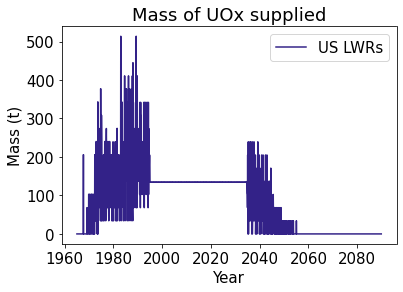

In [11]:
# Comparing fresh_uox transactions to all reactors

plt.plot(current_uox['Year'], current_uox['Quantity']/1000,
         label='US LWRs', color=mycolors[0])
plt.legend() #(loc=2)
plt.ylabel('Mass (t)')
plt.xlabel('Year')
plt.title('Mass of UOx supplied')

Text(0.5, 1.0, 'Cumulative Mass of UOx supplied')

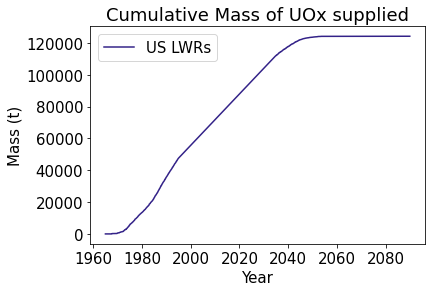

In [12]:
plt.plot(current_uox['Year'], current_uox['Quantity'].cumsum()/1000,
         label='US LWRs', color=mycolors[0])
plt.legend()
plt.ylabel('Mass (t)')
plt.xlabel('Year')
plt.title('Cumulative Mass of UOx supplied')

## SWU Calcs
SWU = $(P*V(x_p) + T*V(x_t) - F*V(x_f))*t$

V($x_i$) = $(2*x_i-1)*\ln(x_i/(1-x_i))$

In [13]:
#Defining assays for LEU product, tails, and feed material
leu_p = 0.045
x_f = 0.00711
x_t = 0.002

In [14]:
current_tails = dta.calculate_tails(current_uox['Quantity'], leu_p, x_t, x_f)
current_feed = dta.calculate_feed(current_uox['Quantity'], current_tails)
current_swu = dta.calculate_SWU(current_uox['Quantity'], leu_p,
                               current_tails, x_t,
                               current_feed, x_f)
current_swu = current_swu.to_frame().reset_index()
current_swu = current_swu.rename(columns={'Quantity':'SWU', 'index':'Time'})
current_swu = dta.add_year(current_swu)

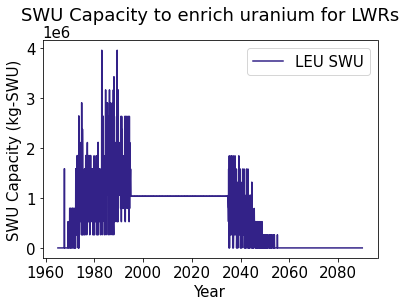

In [15]:
plt.plot(current_swu['Year'], current_swu['SWU'], label='LEU SWU', color=mycolors[0])

plt.xlabel('Year')
plt.ylabel('SWU Capacity (kg-SWU)')
title = plt.title('SWU Capacity to enrich uranium for LWRs', pad=20)
plt.legend()

## Waste Calcs

In [16]:
spent_uox = dta.commodity_mass_traded(current_transactions, 'spent_uox')

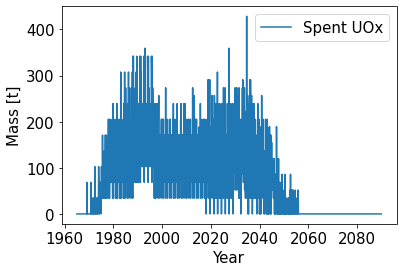

In [17]:
plt.plot(spent_uox['Year'], spent_uox['Quantity']/1000, label='Spent UOx')

plt.ylabel('Mass [t]')
plt.xlabel('Year')
plt.legend()

## Check Waste Script
It doesn't make sense for this notebook, but this is to make sure it works with the scripts in this repo.

In [18]:
w = spent_uox.to_dict()

# create the empty waste dictionary
waste = {'Year':np.zeros(len(w['Year'])),
        'Quantity':np.zeros(len(w['Year']))}

# populate the waste dictionary with the spent_uox values
for year in range(len(w['Year'])):
    waste['Year'][year] = w['Year'][year]
    waste['Quantity'][year] = w['Quantity'][year]/1000 # mass in tons

# convevert the waste dictionary into masses in the format that Cask_Calcs requires
masses = {year: quantity for year, quantity in zip(waste['Year'], waste['Quantity'])}

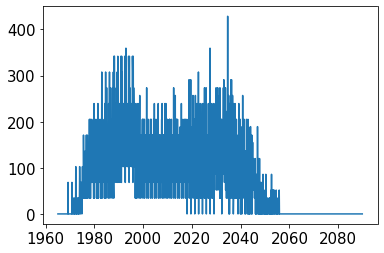

In [19]:
plt.plot(waste['Year'],waste['Quantity'])

In [20]:
import waste_calcs

elements = 'prism'
cask_vol = 12.1
den_kernel = 2
vol_kernel = 0.1
mass_kernel = 0.2
vol_triso = 1
mass_triso = 0.4
den_triso = 1.2
vol_prism = 4
mass_prism = 3

casks_test = waste_calcs.Cask_Calcs(elements,  masses, cask_vol,
                 den_kernel, vol_kernel, mass_kernel,
                 vol_triso, mass_triso, den_triso,
                 vol_prism, mass_prism)

In [21]:
casks_test.calculate_num_kernels()

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
num_casks = casks_test.calculate_casks()

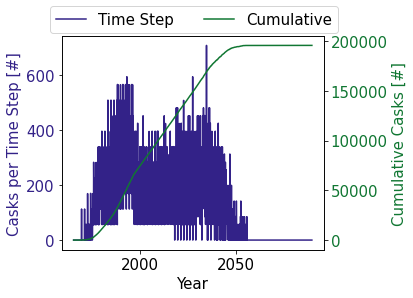

In [23]:
fig, ax1 = plt.subplots()

color = mycolors[0]
ax1.set_xlabel('Year')
ax1.set_ylabel('Casks per Time Step [#]', color=color)
ax1.plot(waste['Year'], num_casks[0], color=color, label='Time Step')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = mycolors[1]
ax2.set_ylabel('Cumulative Casks [#]', color=color)
ax2.plot(waste['Year'], num_casks[0].cumsum(), color=color, label='Cumulative')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.47, 1.07), ncol=2)
plt.show()

In [24]:
num_casks[1][-1]

0.8853262916071856

In [4]:
test_out = 'output_files/output_deployinst.sqlite'

In [5]:
test_lwr = ['UraniumMine', 'FuelFab', 'SeparationsFacility',
               'EnrichmentPlant', '1178MWe BRAIDWOOD-1', '1000MWe Lightwater-1', 'ALWR-1000', 'United States Nuclear',
               'USA', 'Exelon Reactors', 'NuclearRepository', 'ExampleInstitution']

In [9]:
test_reactors = tm.get_lwr_totals(test_out, test_lwr)
test_reactors = dta.add_year(test_reactors)

In [14]:
max(test_reactors['lwr_total'])

1.0

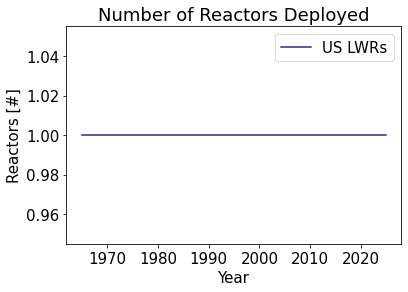

In [11]:
plt.plot(test_reactors['Year'], test_reactors['lwr_total'], label='US LWRs', color=mycolors[0])
plt.title('Number of Reactors Deployed')
plt.xlabel('Year')
plt.ylabel('Reactors [#]')
# plt.yscale('log')
plt.legend()